In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download alxmamaev/flowers-recognition

In [ ]:
# !unzip flowers-recognition.zip

In [ ]:
from google.colab  import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [ ]:
classifier=tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", output_shape=(224,224,3))])

### loading and creating the dataset

In [ ]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (224,224),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [ ]:
# extract the image array and class name
img_data, class_name =create_dataset('/content/drive/MyDrive/flowers')

In [ ]:
## convert unique label values into their actual names
## flower name is the key and label num is the value pair
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
target_val=[target_dict[class_name[i]] for i in range(len(class_name))]

In [ ]:
## splitting the dataset from training and testing
from sklearn.model_selection import train_test_split
train_img,test_img,train_class,test_class = train_test_split(img_data,target_val,random_state =42,test_size = 0.2)

## using transfer learning to finetune the flower classification model

In [ ]:
feature_extraction="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
model_without_top_layer=tf.keras.Sequential([
    hub.KerasLayer(feature_extraction,input_shape=(224,224,3),trainable=False)
])

In [ ]:
final_model=tf.keras.Sequential([
    model_without_top_layer,
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(5)
])
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,342,213
Trainable params: 84,229
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.2),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['acc'])
history=final_model.fit(np.array(train_img),np.array(train_class),epochs=10,validation_split=0.1)

Epoch 1/10
98/98 [==============================] - 19s 66ms/step - loss: 93.1436 - acc: 0.6971 - val_loss: 6.8892 - val_acc: 0.6532
Epoch 2/10
98/98 [==============================] - 5s 47ms/step - loss: 0.8720 - acc: 0.8584 - val_loss: 1.2958 - val_acc: 0.8382
Epoch 3/10
98/98 [==============================] - 5s 48ms/step - loss: 0.3904 - acc: 0.8999 - val_loss: 0.9772 - val_acc: 0.8439
Epoch 4/10
98/98 [==============================] - 5s 49ms/step - loss: 0.3160 - acc: 0.9125 - val_loss: 0.8654 - val_acc: 0.8526
Epoch 5/10
98/98 [==============================] - 5s 47ms/step - loss: 0.1654 - acc: 0.9446 - val_loss: 0.9117 - val_acc: 0.8410
Epoch 6/10
98/98 [==============================] - 5s 50ms/step - loss: 0.1055 - acc: 0.9652 - val_loss: 0.8829 - val_acc: 0.8728
Epoch 7/10
98/98 [==============================] - 5s 47ms/step - loss: 0.0897 - acc: 0.9730 - val_loss: 0.9402 - val_acc: 0.8439
Epoch 8/10
98/98 [==============================] - 5s 48ms/step - loss: 0.0687 -

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


### plotting test and train accuracy

<Figure size 432x288 with 0 Axes>

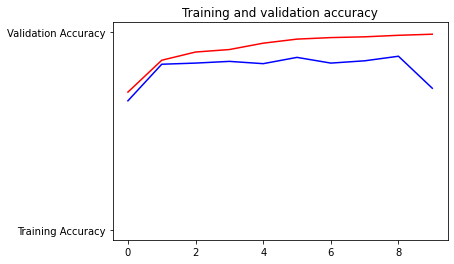

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



In [ ]:
a=final_model.predict(np.array(test_img))

In [ ]:
test_outputs=[]
for i in range(len(a)):
    test_outputs.append(np.argmax(a[i]))

In [ ]:
q=np.array(test_outputs)-test_class

In [ ]:
(q==0).sum()

625

## taking user input and predicting

In [ ]:
getLocalFiles()

In [ ]:
image=Image.open("daisy-flower-1532449822.jpg").resize((224,224))


In [ ]:
image=np.array(image)/255

In [ ]:
final_image=image[np.newaxis,...]

In [ ]:
ans=np.argmax(final_model.predict(final_image))

In [ ]:
print(target_dict.keys())

dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])


In [ ]:
def getKey(val,target_dict):
  for key, value in target_dict.items():
    if value==val:
      return key

The flower given is  daisy


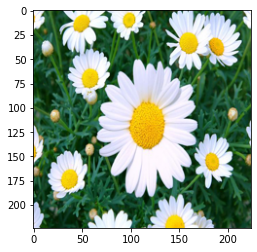

In [ ]:
plt.imshow(image)
print("The flower given is ",getKey(ans,target_dict))